# Part 1

# Importing data from Wiki page through web scraping

In [78]:
# Importing libraries

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

In [4]:
# Defining url and sending request

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
data = requests.get(url).text

In [5]:
# Creating bs object

soup = BeautifulSoup(data, 'html5lib')

In [6]:
# Creating a list and filling it with the infos gathered from the table

table_contents = []
table = soup.find('table')

for row in table.findAll('td'):
    cell = {}
    # Skipping not assigned 
    if row.span.text=='Not assigned':
        pass
    else:
        # Writing postal code, Borough and finally for neighborhood removing parenthesis and spaces and replacing / with ,
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
        
# Print first elements to check
print(table_contents[:5])

[{'PostalCode': 'M3A', 'Borough': 'North York', 'Neighborhood': 'Parkwoods'}, {'PostalCode': 'M4A', 'Borough': 'North York', 'Neighborhood': 'Victoria Village'}, {'PostalCode': 'M5A', 'Borough': 'Downtown Toronto', 'Neighborhood': 'Regent Park, Harbourfront'}, {'PostalCode': 'M6A', 'Borough': 'North York', 'Neighborhood': 'Lawrence Manor, Lawrence Heights'}, {'PostalCode': 'M7A', 'Borough': "Queen's Park", 'Neighborhood': 'Ontario Provincial Government'}]


In [7]:
# Creating pandas dataframe, replacing specific Borough as specified in the notes

df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [8]:
# Showing shapes of df

df.shape

(103, 3)

# Part 2

# Getting latitude and longitude of each neighborhood

In [9]:
# Gathering data from csv
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_3fed46fed6cd40b2a4e7e92a36ebedce = 'https://s3.eu-geo.objectstorage.softlayer.net'
else:
    endpoint_3fed46fed6cd40b2a4e7e92a36ebedce = 'https://s3.eu-geo.objectstorage.service.networklayer.com'

client_3fed46fed6cd40b2a4e7e92a36ebedce = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='DQhrU0ggTQmRhMaMuSQGBn2Xxx-xtjwNzlCfDKOarUcE',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_3fed46fed6cd40b2a4e7e92a36ebedce)

body = client_3fed46fed6cd40b2a4e7e92a36ebedce.get_object(Bucket='finalprojecttorontoneighborhoods-donotdelete-pr-sanlfdtrhyloov',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

latlon_data = pd.read_csv(body)
latlon_data.head()


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
latlon_data[latlon_data['Postal Code'] == 'M1B']['Latitude'].iloc[0]

43.806686299999996

In [11]:
# Adding Lat and Lon

df['Lat'] = ''
df['Lon'] = ''

for code in df.PostalCode.unique():
    df.loc[df['PostalCode'] == code, 'Lat'] = format(latlon_data[latlon_data['Postal Code'] == code]['Latitude'].iloc[0], '.6f')
    df.loc[df['PostalCode'] == code, 'Lon'] = format(latlon_data[latlon_data['Postal Code'] == code]['Longitude'].iloc[0], '.6f')
    
df.head(10)

,PostalCode,Borough,Neighborhood,Lat,Lon
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


# Part 3

# Clustering of Toronto Boroughs

### First I get only boroughs containing Toronto

In [12]:
toronto_df = df.loc[df['Borough'].str.contains('Toronto')]

In [13]:
# Getting geographical coordinates of Toronto

from geopy.geocoders import Nominatim 

address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print("Coordinates for Toronto - Lat: {}\tLon: {}".format(latitude,longitude))

Coordinates for Toronto - Lat: 43.6534817	Lon: -79.3839347


In [14]:
!pip install folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 6.8 MB/s  eta 0:00:01


In [15]:
import folium

# create map of Toronto
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_df['Lat'], toronto_df['Lon'], toronto_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Using Foursquare API to explore neighborhoods

In [40]:
# Using the same function as in lab to get nearby places of Toronto

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [41]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Lat'],
                                   longitudes=toronto_df['Lon']
                                  )

Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Enclave of M5E
St. James Town, Cabbagetown
First Canadi

In [42]:
# Visualizing venue counts in neighborhoods
toronto_venues.groupby('Neighborhood')['Venue'].count()

Neighborhood
Berczy Park                                                                                                    59
Brockton, Parkdale Village, Exhibition Place                                                                   25
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport     16
Central Bay Street                                                                                             59
Christie                                                                                                       16
Church and Wellesley                                                                                           78
Commerce Court, Victoria Hotel                                                                                100
Davisville                                                                                                     37
Davisville North                                                           

In [43]:
# From here, we can take a deeper look on frequencies of different venues categories in neighborhoods and cluster the nh taking this into consideration
# First we have to create dummy variables

toronto_dummies = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column
toronto_dummies['Neighborhood'] = toronto_venues['Neighborhood'] 

toronto_dummies.head()

,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Now we can groupby nh and get freq

toronto_grouped = toronto_dummies.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.016949,0.00000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000,0.040000
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0625,0.0625,0.0625,0.0625,0.1875,0.125,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000
3,Central Bay Street,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.016949,0.00000,0.000000,0.016949,0.016949
4,Christie,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000
5,Church and Wellesley,0.012821,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.012821,0.000000,...,0.012821,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000,0.025641
6,"Commerce Court, Victoria Hotel",0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.030000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.020000,0.00000,0.000000,0.010000,0.000000
7,Davisville,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.027027,0.00000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000
8,Davisville North,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000
9,"Dufferin, Dovercourt Village",0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000


In [44]:
# Now we can make clusters
# Let's find "best" k to use
from tqdm import tqdm
from sklearn.cluster import KMeans

toronto_grouped_clust = toronto_grouped.drop('Neighborhood', axis=1).copy()
inertias = []

K = range(1,8)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k, init='k-means++', n_init=50, random_state=123)
    cluster_labels = kmeanModel.fit_predict(toronto_grouped_clust)
    inertias.append(kmeanModel.inertia_)

100%|██████████| 7/7 [00:01<00:00,  6.49it/s]


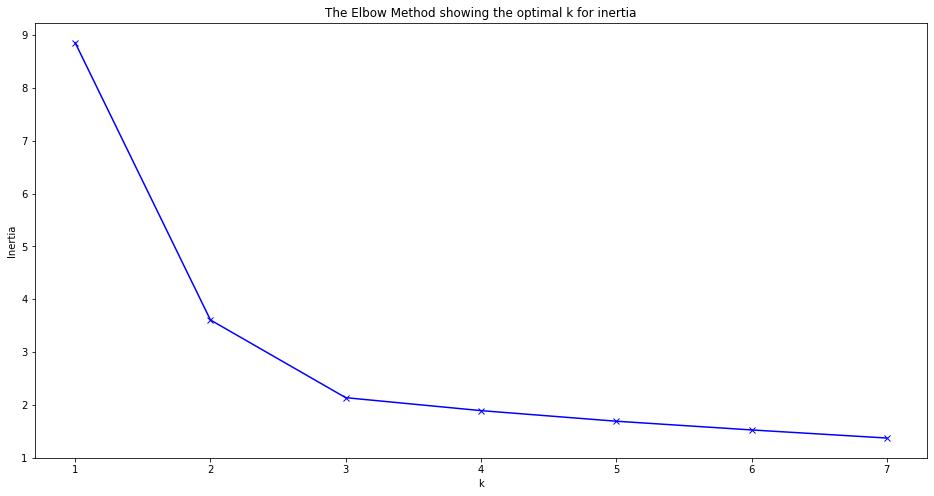

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k for inertia')
plt.show()

### I'd use k=3

In [68]:
k = 3

kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=50, random_state=123).fit(toronto_grouped_clust)

toronto_grouped['KM_LAB'] = kmeans_model.labels_
toronto_grouped.head()

,Neighborhood,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio,KM_LAB
0,Berczy Park,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0,0.0,0.0,0.016949,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.016949,0.050847,0.000000,0.00,0.0,0.016949,0.016949,0.0,0.033898,0.0,0.0,0.016949,0.0,0.0000,0.0,0.0000,0.0,0.016949,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.016949,0.0,0.0000,0.0,0.033898,0.0,0.0,0.0,0.00,0.016949,0.067797,0.101695,0.0,0.0,0.0,0.0,0.016949,0.000000,0.016949,0.00,0.0,0.0,0.016949,0.0,0.0,0.0,0.0,0.016949,0.0,0.0,0.016949,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949,0.0,0.0,0.0,0.0,0.000000,0.033898,0.0,0.0,0.0,0.016949,0.0,0.0,0.0,0.0,0.016949,0.016949,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,

In [69]:
toronto_grouped.KM_LAB.value_counts()

2    33
1     5
0     1
Name: KM_LAB, dtype: int64

In [70]:
pd.set_option('display.max_column', None)

In [71]:
toronto_grouped.drop('Neighborhood', axis=1).groupby('KM_LAB').mean()

,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
KM_LAB,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [72]:
# Adding label to main df

toronto_final = toronto_df.merge(toronto_grouped[['Neighborhood', 'KM_LAB']].set_index('Neighborhood'), on='Neighborhood')
toronto_final.head()

,PostalCode,Borough,Neighborhood,Lat,Lon,KM_LAB
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,2
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2


In [75]:
# Lets plot cluster on the map

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color for the clusters
col_dict = {
    0: 'red',
    1: 'blue',
    2: 'green'
}

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_final['Lat'], toronto_final['Lon'], toronto_final['Neighborhood'], toronto_final['KM_LAB']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=col_dict.get(cluster),
        fill=True,
        fill_color=col_dict.get(cluster),
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Looks like there's one predominant cluster

In [76]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [96]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_venues_sorted = pd.DataFrame(columns=columns)
toronto_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.drop('KM_LAB', 1).iloc[ind, :], num_top_venues)

toronto_venues_sorted['KM_LAB'] = toronto_grouped['KM_LAB']

In [98]:
# Cluster = 2, 5 most common placs
toronto_venues_sorted.loc[toronto_venues_sorted['KM_LAB'] == 2, toronto_venues_sorted.columns[[0] + list(range(1, 6))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Farmers Market,Beer Bar
1,"Brockton, Parkdale Village, Exhibition Place",Café,Bakery,Breakfast Spot,Coffee Shop,Yoga Studio
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Coffee Shop,Harbor / Marina,Plane
3,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Burger Joint
4,Christie,Grocery Store,Café,Park,Baby Store,Coffee Shop
5,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar
6,"Commerce Court, Victoria Hotel",Coffee Shop,Restaurant,Hotel,Café,Italian Restaurant
7,Davisville,Sandwich Place,Dessert Shop,Pizza Place,Coffee Shop,Café
8,Davisville North,Park,Pizza Place,Hotel,Food & Drink Shop,Sandwich Place
9,"Dufferin, Dovercourt Village",Pharmacy,Bakery,Grocery Store,Café,Liquor Store


In [100]:
# Cluster = 1, 5 most common placs
toronto_venues_sorted.loc[toronto_venues_sorted['KM_LAB'] == 1, toronto_venues_sorted.columns[[0] + list(range(1, 6))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,Forest Hill North & West,Park,Jewelry Store,Trail,Sushi Restaurant,Department Store
19,Lawrence Park,Park,Dim Sum Restaurant,Swim School,Bus Line,Event Space
21,"Moore Park, Summerhill East",Restaurant,Trail,Park,Colombian Restaurant,Department Store
26,Rosedale,Park,Playground,Trail,Deli / Bodega,Electronics Store
35,The Danforth East,Park,Coffee Shop,Convenience Store,Intersection,Yoga Studio


In [101]:
# Cluster = 0, 5 most common placs
toronto_venues_sorted.loc[toronto_venues_sorted['KM_LAB'] == 0, toronto_venues_sorted.columns[[0] + list(range(1, 6))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
27,Roselawn,Home Service,Garden,Yoga Studio,Department Store,Escape Room
